In [1]:
import sys
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import tqdm


In [2]:
environment_variables = dict(os.environ)
if "SCRATCH_STORAGE_DIR" in environment_variables:
    SCRATCH_STORAGE_DIR = Path(environment_variables["SCRATCH_STORAGE_DIR"]).resolve()
else:
    SCRATCH_STORAGE_DIR = Path(".").resolve()

data_dir = SCRATCH_STORAGE_DIR / "data"
data_dir.mkdir(parents=True, exist_ok=True)
print(f"Data directory: {data_dir}")

Data directory: /scratch/aplesner/difflogic-tonic/data


In [3]:
class FilteredImageDataset(Dataset):
    """Dataset that applies CV filters and thresholds to Boolean images."""
    
    def __init__(self, base_dataset: Dataset, threshold: float = 0.1):
        self.base_dataset = base_dataset
        self.threshold = threshold
        
        # Define all CV kernels as a list
        self.kernels = [
            # Best gradient edge detectors (keep only Scharr - better than Sobel/Prewitt)
            torch.tensor([[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]], dtype=torch.float32),  # Scharr X
            torch.tensor([[-3, -10, -3], [0, 0, 0], [3, 10, 3]], dtype=torch.float32),  # Scharr Y
            
            # Omnidirectional edge detector
            torch.tensor([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=torch.float32),  # Laplacian
            
            # Blob detector
            torch.tensor([[0, 0, -1, 0, 0], [0, -1, -2, -1, 0], [-1, -2, 16, -2, -1], 
                         [0, -1, -2, -1, 0], [0, 0, -1, 0, 0]], dtype=torch.float32),  # LoG
            
            # Ridge/line detectors (4 orientations: 0°, 45°, 90°, 135°)
            torch.tensor([[-1, -1, -1], [2, 2, 2], [-1, -1, -1]], dtype=torch.float32),  # Horizontal line
            torch.tensor([[-1, 2, -1], [-1, 2, -1], [-1, 2, -1]], dtype=torch.float32),  # Vertical line
            torch.tensor([[2, -1, -1], [-1, 2, -1], [-1, -1, 2]], dtype=torch.float32),  # Diagonal line (45°)
            torch.tensor([[-1, -1, 2], [-1, 2, -1], [2, -1, -1]], dtype=torch.float32),  # Diagonal line (135°)
            
            # Emboss filters (directional texture)
            torch.tensor([[-2, -1, 0], [-1, 1, 1], [0, 1, 2]], dtype=torch.float32),  # Emboss NW-SE
            torch.tensor([[0, 1, 2], [-1, 1, 1], [-2, -1, 0]], dtype=torch.float32),  # Emboss NE-SW
            
            # High-pass filter (fine details)
            torch.tensor([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype=torch.float32),  # Sharpen
            
            # Difference-type filters
            torch.tensor([[1, 1, 1], [1, 1, 1], [-2, -2, -2]], dtype=torch.float32),  # Top-Bottom difference
            torch.tensor([[1, 1, -2], [1, 1, -2], [1, 1, -2]], dtype=torch.float32),  # Left-Right difference
            
            # Corner-like response (simplified)
            torch.tensor([[-1, 0, 1], [0, 0, 0], [1, 0, -1]], dtype=torch.float32),  # Corner detector
        ]
        
        # Add dimensions for conv2d: [out_channels, in_channels, H, W]
        self.kernels = [k.unsqueeze(0).unsqueeze(0) for k in self.kernels]

        # Precompute padding sizes
        self.paddings = [k.shape[-1] // 2 for k in self.kernels]

    def apply_filter(self, img: torch.Tensor, kernel: torch.Tensor, padding: int) -> torch.Tensor:
        """Apply convolution filter and threshold to Boolean."""
        
        # Apply convolution
        filtered = F.conv2d(img, kernel, padding=padding)

        # Normalize and threshold to Boolean
        filtered = torch.abs(filtered)
        filtered = filtered / (filtered.max() + 1e-8)
        boolean_img = (filtered > self.threshold).float().squeeze()
        
        return boolean_img
    
    def __getitem__(self, idx: int) -> tuple[torch.Tensor, int]:
        img, label = self.base_dataset[idx]

        # Convert to grayscale if RGB
        if img.shape[0] == 3:
            img = 0.299 * img[0] + 0.587 * img[1] + 0.114 * img[2]
            img = img.unsqueeze(0)
        else:
            img = img.unsqueeze(0)

        # Apply all filters
        filtered_outputs = [self.apply_filter(img, kernel, padding) for kernel, padding in zip(self.kernels, self.paddings)]
        
        # Stack into N-channel output
        filtered_img = torch.stack(filtered_outputs)
        
        return filtered_img, label
    
    def __len__(self) -> int:
        return len(self.base_dataset)  # type: ignore


In [4]:
cifar10 = True

# Example usage with CIFAR-10
# if __name__ == "__main__":
# Load CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
])

if cifar10:
    cifar_train = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
    cifar_test = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)
else:
    cifar_train = datasets.CIFAR100(root=data_dir, train=True, download=True, transform=transform)
    cifar_test = datasets.CIFAR100(root=data_dir, train=False, download=True, transform=transform)

# Create filtered dataset
filtered_dataset_train = FilteredImageDataset(cifar_train, threshold=0.2)
filtered_dataset_test = FilteredImageDataset(cifar_test, threshold=0.2)

# Create dataloader
train_dataloader = DataLoader(filtered_dataset_train, batch_size=32, shuffle=True, num_workers=4, prefetch_factor=5)
test_dataloader = DataLoader(filtered_dataset_test, batch_size=32, shuffle=False, num_workers=4, prefetch_factor=5)

# Test
for batch_imgs, batch_labels in test_dataloader:
    print(f"Batch shape: {batch_imgs.shape}")  # [32, 14, 32, 32]
    print(f"Labels shape: {batch_labels.shape}")  # [32]
    print(f"Values are Boolean: {torch.all((batch_imgs == 0) | (batch_imgs == 1))}")

    break

Files already downloaded and verified
Files already downloaded and verified
Batch shape: torch.Size([32, 14, 32, 32])
Labels shape: torch.Size([32])
Values are Boolean: True


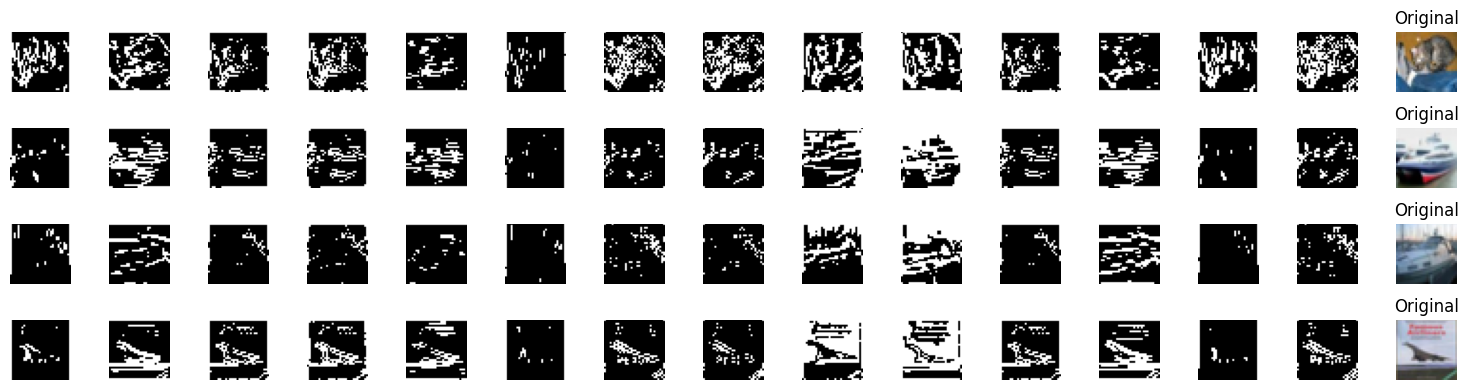

In [5]:
# Plot the first four images' 14 channels and their original
fig, axes = plt.subplots(4, 15, figsize=(15, 4))
for i in range(4):
    img, label = filtered_dataset_test[i]
    for j in range(img.shape[0]):
        axes[i, j].imshow(img[j], cmap='gray')
        axes[i, j].axis('off')
    # Original image
    orig_img, _ = cifar_test[i]
    orig_img = np.transpose(orig_img.numpy(), (1, 2, 0))
    axes[i, -1].imshow(orig_img)
    axes[i, -1].axis('off')
    axes[i, -1].set_title('Original')
plt.tight_layout()
plt.show()

In [6]:
# from src import model as src_model
# from src import model_config as src_model_config
import importlib
import convolutional_lut
import difflut

importlib.reload(convolutional_lut)

<module 'convolutional_lut' from '/home/aplesner/code/difflogic-tonic/convolutional_lut.py'>

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self, cifar10: bool = True):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(14, 32, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.flatten_size = 64 * 4 * 4
        if cifar10:
            self.fc1 = torch.nn.Linear(self.flatten_size, 128)
            self.fc2 = torch.nn.Linear(128, 10)
        else:
            self.fc1 = torch.nn.Linear(self.flatten_size, 256)
            self.fc2 = torch.nn.Linear(256, 100)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.activation = nn.LeakyReLU()
    
    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = self.pool(self.activation(self.conv3(x)))
        x = x.view(-1, self.flatten_size)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

def evaluate(net: nn.Module, dataloader: DataLoader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm.tqdm(
            dataloader, desc="Evaluating", total=len(dataloader), unit="batch", ncols=100
        )
        for inputs, labels in pbar:
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

def train(net: nn.Module, train_dataloader: DataLoader, test_dataloader: DataLoader, epochs=5, difflogic: bool = False, learning_rate: float = 0.01):
    criterion = nn.CrossEntropyLoss()
    if difflogic:
        # Use a different optimizer for DiffLogic
        optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    else:
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0
        pbar = tqdm.tqdm(
            enumerate(train_dataloader), 
            desc=f"Training ({epoch+1}/{epochs})", 
            total=len(train_dataloader), 
            unit="batch", ncols=100
        )
        pbar.set_postfix(loss=np.inf, accuracy=0.0)
        for i, (inputs, labels) in pbar:
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()
            
            running_loss += loss.item()
            if i % 100 == 99:  # Print every 1000 mini-batches
                accuracy = 100 * running_correct / running_total
                pbar.set_postfix(loss=running_loss / 1000, accuracy=accuracy)
                running_loss = 0.0
                running_correct = 0
                running_total = 0
        evaluate(net, test_dataloader)
    print("Finished Training")
    return optimizer

In [8]:
net = SimpleCNN(cifar10=cifar10)
if torch.cuda.is_available():
    print("Using CUDA")
    net = net.cuda()

train(net, train_dataloader, test_dataloader, epochs=3, difflogic=False, learning_rate=0.001)

Using CUDA


Evaluating: 100%|█████████████████████████████████████████████| 313/313 [00:03<00:00, 101.25batch/s]

Accuracy: 60.88%



Evaluating: 100%|█████████████████████████████████████████████| 313/313 [00:02<00:00, 104.87batch/s]

Accuracy: 65.62%



Evaluating: 100%|█████████████████████████████████████████████| 313/313 [00:03<00:00, 102.76batch/s]

Accuracy: 66.67%
Finished Training


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [ ]:
import time
class DifflogicCNN(nn.Module):
    def __init__(self, tau: float = 1, cifar10: bool = True):
        super(DifflogicCNN, self).__init__()
        self.conv_channels = [128]
        self.n_neurons_fc = 32_000
        start_time = time.time()
        prev_channels = 14
        self.convs = nn.ModuleList()
        for i, out_channels in enumerate(self.conv_channels):
            conv = convolutional_lut.ConvolutionalLUTLayer(
                tree_depth=1,
                in_channels=prev_channels,
                out_channels=out_channels,
                receptive_field=5,
                stride=1,
                padding=2,
                node_type='dwn_stable',
                n_inputs_per_node=4,
            )
            self.convs.append(conv)
            prev_channels = out_channels

        n_layers = len(self.conv_channels)
        self.flatten_size = self.conv_channels[-1] * (32 // (2**n_layers))**2  # After 3 poolings
        print(f"Conv layers initialized in {time.time() - start_time:.2f} seconds.")
        start_time = time.time()

        num_classes = 10 if cifar10 else 100
        node_type = difflut.REGISTRY.get_node('dwn_stable')


        self.fc1 = difflut.RandomLayer(
            input_size=self.flatten_size,
            output_size=self.n_neurons_fc,
            node_type=node_type,
            node_kwargs={'input_dim': 4, 'output_dim': 1},
        )
        self.fc2 = difflut.RandomLayer(
            input_size=self.n_neurons_fc,
            output_size=self.n_neurons_fc,
            node_type=node_type,
            node_kwargs={'input_dim': 4, 'output_dim': 1},
        )

        print(f"FC layers initialized in {time.time() - start_time:.2f} seconds.")
        start_time = time.time()

        self.groupsum = difflut.GroupSum(k=num_classes, tau=tau*np.sqrt(self.n_neurons_fc))

        self.fc = nn.Sequential(
            self.fc1,
            self.fc2,
            self.groupsum,
        )

        self.pool = nn.MaxPool2d(2, 2)
        print(f"DifflogicCNN initialized in {time.time() - start_time:.2f} seconds.")
    
    def forward(self, x):
        for conv in self.convs:
            x = conv(x)
            x = self.pool(x)
        x = x.reshape(-1, self.flatten_size)
        x = self.fc(x)
        return x

In [24]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

net_difflogic_cnn = DifflogicCNN(tau=1, cifar10=cifar10)

if torch.cuda.is_available():
    print("Using CUDA")
    net_difflogic_cnn = net_difflogic_cnn.cuda()


Using CUDA


In [25]:
optimizer = train(net_difflogic_cnn, train_dataloader, test_dataloader, epochs=5, difflogic=True, learning_rate=0.002)

Evaluating: 100%|██████████████████████████████████████████████| 313/313 [00:03<00:00, 86.81batch/s]

Accuracy: 38.91%



Evaluating: 100%|██████████████████████████████████████████████| 313/313 [00:03<00:00, 89.96batch/s]

Accuracy: 39.75%



Evaluating: 100%|██████████████████████████████████████████████| 313/313 [00:03<00:00, 88.28batch/s]

Accuracy: 41.03%



Evaluating: 100%|██████████████████████████████████████████████| 313/313 [00:03<00:00, 89.05batch/s]

Accuracy: 37.43%



Evaluating: 100%|██████████████████████████████████████████████| 313/313 [00:03<00:00, 89.07batch/s]

Accuracy: 40.88%
Finished Training


In [ ]:
batch = next(iter(train_dataloader))
if torch.cuda.is_available():
    inputs, labels = batch[0].cuda(), batch[1].cuda()
else:
    inputs, labels = batch[0], batch[1]

outputs = net_difflogic_cnn(inputs)

In [ ]:
outputs

tensor([[39.6254, 37.6778, 39.6854, 39.3923, 39.2448, 40.4505, 39.2656, 39.1003,
         39.7004, 38.0170],
        [41.1826, 38.3826, 39.1999, 37.6059, 39.0840, 37.7553, 38.8998, 38.6165,
         39.5940, 38.1484],
        [36.9055, 40.5862, 38.5804, 39.4351, 37.3315, 38.2573, 39.6236, 39.3172,
         38.4801, 39.7481],
        [40.4342, 38.4791, 40.0419, 38.5250, 40.3312, 37.5671, 38.0712, 38.3642,
         38.9171, 37.9376],
        [38.9201, 39.8781, 37.9176, 40.5756, 37.8525, 40.0851, 37.1061, 40.3644,
         39.4188, 40.9549],
        [40.5020, 38.3631, 39.3271, 39.2136, 38.6381, 39.0640, 37.8557, 37.7307,
         39.5705, 37.0122],
        [39.1754, 39.3003, 39.4320, 38.7975, 39.6434, 39.3159, 38.8216, 39.7834,
         40.1198, 41.1117],
        [37.4380, 35.8639, 39.9478, 40.9191, 39.5887, 40.0025, 38.2739, 39.9290,
         37.1901, 38.4372],
        [38.8171, 42.3894, 37.7298, 38.1402, 38.8319, 38.1076, 39.2408, 39.3872,
         40.4925, 40.4579],
        [37.9730, 3